In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.stats as spstat
import scipy.sparse.linalg as spsplin
import scipy.sparse as spsp
%matplotlib inline
plt.rc("text", usetex=True)
import time
import sys
sys.path.insert(0, '../src/')

import sai

import pyamg

## Generate matrix $A$ 

In [2]:
n = 128
stencil = pyamg.gallery.diffusion_stencil_2d(epsilon=5000, theta=np.pi / 4, type="FD")
A = pyamg.gallery.stencil_grid(stencil, (n, n), format="csc")

In [3]:
A.shape, A.min(), A.max()

((16384, 16384), -2500.5000000000005, 10002.0)

In [4]:
n_vec = 1
# u_trial = np.random.randn(A.shape[0], n_vec)
x0, y0 = (0, 0.)
x_range = np.linspace(-1, 1, num=n)
y_range = np.linspace(-1, 1, num=n)
rv = spstat.multivariate_normal([x0, y0], [[0.05, 0.0], [0.0, 0.05]])
x, y = np.meshgrid(x_range, y_range)
pos = np.dstack((x, y))
u0 = rv.pdf(pos)

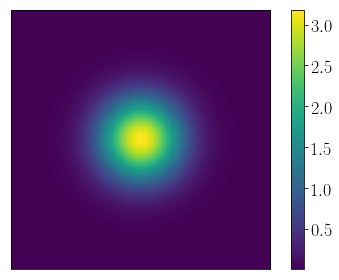

In [5]:
plt.imshow(u0)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

In [6]:
u_trial = u0.reshape(n*n, 1)

In [7]:
tol = 1e-8
maxiter = int(1e5)
start = 0.
stop = 0.1

## Baseline

In [8]:
delta_trial = 0.07
gamma_trial = stop * delta_trial

In [10]:
y_test, _, conv_trial = sai.expm_ArnoldiSAI(A, u0.reshape((n**2, 1)), stop, gamma_trial, tol, 1000)

Computing sparse LU factorization of the SAI matrix...
Done
Iteration = 1, resnorm = 12.24408643346828
Iteration = 2, resnorm = 7.256146859153671
Iteration = 3, resnorm = 4.588458919836486
Iteration = 4, resnorm = 2.1832356693030963
Iteration = 5, resnorm = 0.7167597712992315
Iteration = 6, resnorm = 0.3411777535960848
Iteration = 7, resnorm = 0.2099611215748397
Iteration = 8, resnorm = 0.030961251240748357
Iteration = 9, resnorm = 0.02601955123677154
Iteration = 10, resnorm = 0.006215989219013841
Iteration = 11, resnorm = 0.0002901064282110554
Iteration = 12, resnorm = 0.0005539592598976302
Iteration = 13, resnorm = 0.00011329863306733788
Iteration = 14, resnorm = 2.45115720004734e-05
Iteration = 15, resnorm = 1.2702989963888219e-05
Iteration = 16, resnorm = 2.869159801561751e-06
Iteration = 17, resnorm = 2.05505587985447e-06
Iteration = 18, resnorm = 8.773314639750693e-07
Iteration = 19, resnorm = 2.2823693519254378e-07
Iteration = 20, resnorm = 1.814120138116535e-07
Iteration = 21, 

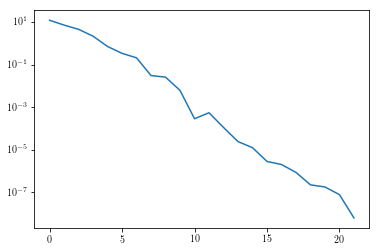

In [11]:
plt.semilogy(conv_trial[conv_trial > 0])

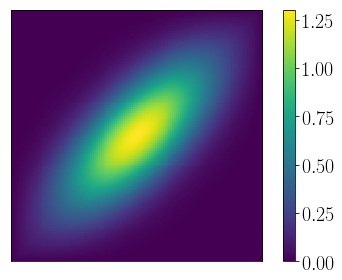

In [12]:
plt.imshow(y_test.reshape((n, n)))
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

## Optimize $\gamma$

In [39]:
# Generate gaussians as trial vectors 
batch_size = 1
# U = np.random.rand(A.shape[0], batch_size)
U = np.zeros((A.shape[0], batch_size))
x_range = np.linspace(-1, 1, num=n)
y_range = np.linspace(-1, 1, num=n)
for k in range(batch_size):
    x0, y0 = 2 * (np.random.rand(2) - 0.5)
#     x0, y0 = np.random.rand(2)
    print(x0, y0)
    rv = spstat.multivariate_normal([x0, y0], [[0.05, 0.0], [0.0, 0.05]])
    x, y = np.meshgrid(x_range, y_range)
    pos = np.dstack((x, y))
    u0 = rv.pdf(pos)
    U[:, k] = u0.reshape(n**2)

-0.3652670985449784 -0.8474378920940413


In [40]:
import scipy.optimize as scopt

In [41]:
max_opt_iter = 15
# tol = 1e-6
# batch_size = 1
# U = np.random.rand(A.shape[0], batch_size)
U0_trial = U
def objective_res(delta):
    gamma = delta * stop
    _, res_norm, _ = sai.expm_ArnoldiSAI(A.tocsc(), U0_trial, stop, gamma, tol, max_opt_iter, False)
    value = np.mean(res_norm**2)
    print("Objective = {}, delta = {}".format(value, delta))
    if np.isnan(value):
        return 100
    else:
        return value
    if value < tol:
        return 0
    else:
        return value
        

In [42]:
start_opt = time.time()
res_brent = scopt.fminbound(objective_res, 0.01, 0.07, xtol=1e-5, full_output=True, maxfun=50)
opt_time = time.time() - start_opt

Objective = 0.0003538476825652241, delta = 0.03291796067500631
Objective = 1.3509754269827294e-06, delta = 0.04708203932499369
Objective = 7.099997256712279e-07, delta = 0.05583592135001262
Objective = 2.3553621081150637e-07, delta = 0.05149279458964487
Objective = 2.4299627603093463e-07, delta = 0.05234397478385632
Objective = 2.3083885361834362e-07, delta = 0.05176609245310102
Objective = 2.2974708243256718e-07, delta = 0.051820805169057474
Objective = 2.253515103301525e-07, delta = 0.052020638180029444
Objective = 2.2232717284340129e-07, delta = 0.05214414177288435
Objective = 2.210948243359049e-07, delta = 0.052220471191001414
Objective = 2.294259460626468e-07, delta = 0.05226764536573926
Objective = 2.211124979240771e-07, delta = 0.0521913159476222
Objective = 2.2070643435386922e-07, delta = 0.05220681372414324
Objective = 2.2079408344562972e-07, delta = 0.05220347961645772
Objective = 2.206186262297762e-07, delta = 0.052210147831828764
Objective = 2.2051457256161196e-07, delta = 

In [43]:
print("Optimal gamma / T = {}".format(res_brent[0]))
print("Optimal gamma = {}".format(res_brent[0] *  stop))
print("Number of function calls = {}".format(res_brent[-1]))
print("Time for optimization = {}".format(opt_time))
gamma_opt_brent = res_brent[0] * stop
num_brent_iter = res_brent[-1]

Optimal gamma / T = 0.052214091004154646
Optimal gamma = 0.005221409100415465
Number of function calls = 16
Time for optimization = 3.3162178993225098


## Plot dependence of time on the number ot test initial states

In [44]:
from IPython.display import clear_output

In [45]:
running_time_brent = [opt_time]
running_time_base = [0.0]
running_iters = 100
brent_running_iters = []
base_running_iters = []

In [46]:
test_batch_size = 300
U_test = np.zeros((n**2, test_batch_size))

In [47]:
for j in range(test_batch_size):    
    x0, y0 = 2 * np.random.rand(2) - 1
    rv = spstat.multivariate_normal([x0, y0], [[0.05, 0.0], [0.0, 0.05]])
    x_range = np.linspace(-1, 1, num=n)
    y_range = np.linspace(-1, 1, num=n)
    x, y = np.meshgrid(x_range, y_range)
    pos = np.dstack((x, y))
    u0 = rv.pdf(pos).reshape((n**2, 1))
    U_test[:, j] = u0.ravel()

In [48]:
I_gammaA_base = spsp.eye(A.shape[0], format="csc") + gamma_trial * A
A_lu_base = spsplin.splu(I_gammaA_base)

In [49]:
 for j in range(test_batch_size):
    if j % 20 == 0:
        print("Index of the processed initial vector =", j)
    u0 = U_test[:, j][:, np.newaxis]
    start_base = time.time()
    _, _, conv_base = sai.expm_ArnoldiSAI(A, u0, stop, gamma_trial, tol, running_iters, False, A_lu_base)
    running_time_base.append(running_time_base[-1] + time.time() - start_base)
    base_running_iters.append(len(conv_base[conv_base > 0]))

Index of the processed initial vector = 0
Index of the processed initial vector = 20
Index of the processed initial vector = 40
Index of the processed initial vector = 60
Index of the processed initial vector = 80
Index of the processed initial vector = 100
Index of the processed initial vector = 120
Index of the processed initial vector = 140
Index of the processed initial vector = 160
Index of the processed initial vector = 180
Index of the processed initial vector = 200
Index of the processed initial vector = 220
Index of the processed initial vector = 240
Index of the processed initial vector = 260
Index of the processed initial vector = 280


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.]),
 <a list of 10 Text yticklabel objects>)

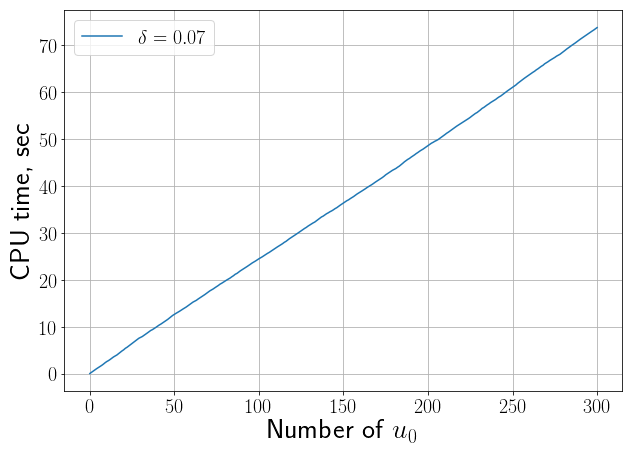

In [50]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(len(running_time_base)), running_time_base, 
                 label=r"$\delta = {}$".format(delta_trial))
plt.xlabel(r"Number of $u_0$", fontsize=28)
plt.ylabel("CPU time, sec", fontsize=28)
plt.grid(True)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [51]:
I_gammaA_brent = spsp.eye(A.shape[0], format="csc") + gamma_opt_brent * A
A_lu_brent = spsplin.splu(I_gammaA_brent)

In [52]:
for j in range(test_batch_size):
    if j % 20 == 0:
        print("Index of the processed initial vector =", j)
    u0 = U_test[:, j][:, np.newaxis]
    start_brent = time.time()
    _, _, conv_brent = sai.expm_ArnoldiSAI(A, u0, stop, gamma_opt_brent, tol, running_iters, False, A_lu_brent)
    running_time_brent.append(running_time_brent[-1] + time.time() - start_brent)
    brent_running_iters.append(len(conv_brent[conv_brent > 0]))

Index of the processed initial vector = 0
Index of the processed initial vector = 20
Index of the processed initial vector = 40
Index of the processed initial vector = 60
Index of the processed initial vector = 80
Index of the processed initial vector = 100
Index of the processed initial vector = 120
Index of the processed initial vector = 140
Index of the processed initial vector = 160
Index of the processed initial vector = 180
Index of the processed initial vector = 200
Index of the processed initial vector = 220
Index of the processed initial vector = 240
Index of the processed initial vector = 260
Index of the processed initial vector = 280


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.]),
 <a list of 10 Text yticklabel objects>)

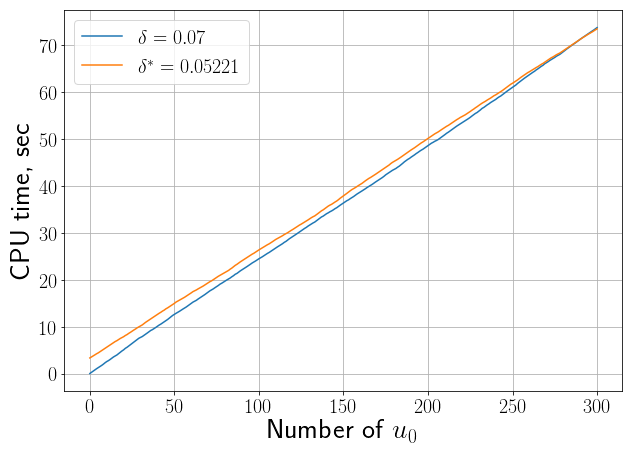

In [53]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(len(running_time_base)), running_time_base, 
         label=r"$\delta = {}$".format(delta_trial))
plt.plot(np.arange(len(running_time_brent)), running_time_brent, 
         label="$\delta^* = {}$".format(np.round(gamma_opt_brent/stop, 5)))
plt.legend(fontsize=20)
plt.xlabel(r"Number of $u_0$", fontsize=28)
plt.ylabel("CPU time, sec", fontsize=28)
plt.grid(True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)